# Question 1
---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random

In [19]:
def joint_posterior(theta, tau, data, theta0, tau0, alpha, lam):
    """
    Computes the unnormalized joint posterior:
    p(theta, tau | x) ∝ p(x | theta, tau) * p(theta) * p(tau)
    
    Args:
      theta : proposed mean
      tau   : proposed precision
      data  : observed data (array)
      theta0: prior mean for theta
      tau0  : prior precision for theta
      alpha : shape of Gamma prior for tau
      lam   : rate of Gamma prior for tau
    
    Returns:
      posterior_value: unnormalized posterior probability
    """
    n = len(data)
    sum_sq = np.sum((data - theta) ** 2)

    # Likelihood (normal with precision tau)
    likelihood = tau**(n/2) * np.exp(-0.5 * tau * sum_sq)

    # Prior for theta (normal with precision tau0)
    prior_theta = np.exp(-0.5 * tau0 * (theta - theta0)**2)

    # Prior for tau (Gamma with shape alpha/2, rate lambda/2)
    prior_tau = tau**(alpha/2 - 1) * np.exp(-lam/2 * tau)

    # Compute unnormalized posterior
    return likelihood * prior_theta * prior_tau

def metropolis_within_gibbs(data, theta0, tau0, alpha, lam, n_iter, burn_in, prop_sd_theta):
    """
    Metropolis-within-Gibbs sampling for Normal(mean=theta, precision=tau),
    using direct evaluation of the joint posterior instead of logs.
    
    Args:
      data     : 1D array of observed data
      theta0   : prior mean for theta
      tau0     : prior precision for theta
      alpha    : shape for Gamma prior on tau
      lam      : rate for Gamma prior on tau
      n_iter   : number of iterations
      burn_in  : number of samples to discard
      prop_sd_theta : proposal standard deviation for theta
      prop_sd_tau   : proposal standard deviation for tau
    
    Returns:
      (theta_samples, tau_samples): Posterior samples after burn-in
    """
    data = np.asarray(data)
    
    # Storage
    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)

    # Initialize parameters
    tau_current = np.random.gamma(shape=alpha/2, scale=1/lam/2)  
    theta_current = np.random.normal(theta0, 1 / np.sqrt(tau0))  

    for t in range(n_iter):
        # -------------------------------------------------
        # Step 1: Metropolis update for theta
        # -------------------------------------------------
        theta_proposed = np.random.normal(theta_current, prop_sd_theta)

        p_current_theta = joint_posterior(theta_current, tau_current, data, theta0, tau0, alpha, lam)
        p_proposed_theta = joint_posterior(theta_proposed, tau_current, data, theta0, tau0, alpha, lam)
        
        acceptance_ratio_theta = p_proposed_theta / p_current_theta
        if np.random.rand() < min(1, acceptance_ratio_theta):
            theta_current = theta_proposed  # Accept

        # -------------------------------------------------
        # Step 2: Metropolis update for tau
        # -------------------------------------------------
        tau_proposed = np.random.exponential(scale = 2)
        
        p_current_tau = joint_posterior(theta_current, tau_current, data, theta0, tau0, alpha, lam)
        p_proposed_tau = joint_posterior(theta_current, tau_proposed, data, theta0, tau0, alpha, lam)
        
        acceptance_ratio_tau = (p_proposed_tau/p_current_tau)*(stats.expon.pdf(tau_current)/stats.expon.pdf(tau_proposed))
        
        if np.random.rand() < min(1, acceptance_ratio_tau):
            tau_current = tau_proposed  # Accept

        # Store samples
        theta_samples[t] = theta_current
        tau_samples[t] = tau_current

    # Discard burn-in
    return theta_samples[burn_in:], tau_samples[burn_in:]

In [26]:
random.seed(10)
np.random.seed(15)

# Generate synthetic data from Normal(50, 1/25)
true_theta = 50
true_tau = 1/25  # Precision = 1 / Variance
data = np.random.normal(true_theta, 1/np.sqrt(true_tau), size=30)

# Set prior hyperparameters
theta0 = 0.0      # Prior mean for theta
tau0   = 0.01     # Prior precision for theta (weak prior)
alpha  = 1.0      # Shape of Gamma prior
lam    = 1.0      # Rate of Gamma prior

#, P_current_theta, P_proposed_theta, P_current_tau, P_proposed_tau, Accept_ratio_theta, Accept_ratio_tau
# Run the sampler
theta_samples, tau_samples = metropolis_within_gibbs(
    data, theta0, tau0, alpha, lam, n_iter=10000, burn_in=300, prop_sd_theta=0.8
)

/tmp/ipykernel_53/3268819266.py:71: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_ratio_theta = p_proposed_theta / p_current_theta
/tmp/ipykernel_53/3268819266.py:83: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_ratio_tau = (p_proposed_tau/p_current_tau)*(stats.expon.pdf(tau_current)/stats.expon.pdf(tau_proposed))
/tmp/ipykernel_53/3268819266.py:83: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_ratio_tau = (p_proposed_tau/p_current_tau)*(stats.expon.pdf(tau_current)/stats.expon.pdf(tau_proposed))


In [27]:
print("Posterior mean of theta:", np.mean(theta_samples))
print("Posterior mean of tau  :", np.mean(tau_samples))

Posterior mean of theta: 49.24137130445129
Posterior mean of tau  : 0.05032685692620071


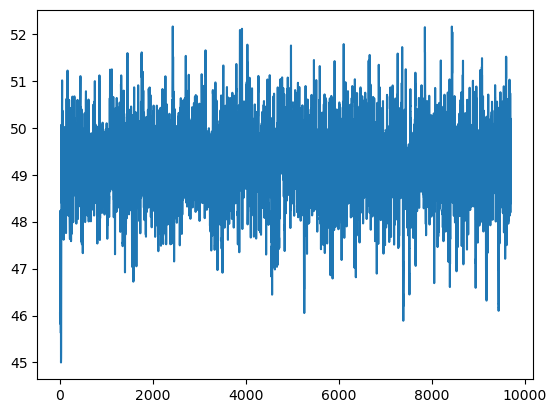

In [28]:
plt.plot(theta_samples)

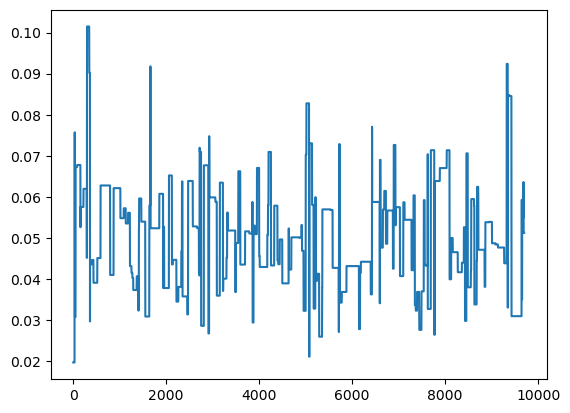

In [29]:
plt.plot(tau_samples)

In [30]:
np.quantile(theta_samples, [0.025, 0.975])

array([47.49001596, 50.87546591])

In [31]:
np.quantile(1/(tau_samples**0.5), [0.025, 0.975])

array([3.70034162, 5.91320907])

Both our credible intervals contain the values assigned to their respective parameters at the beginning of the simulation.

# Question 2
---

In [57]:
def joint_posterior(theta, tau, data, theta0, b, alpha, lam):
    """
    Computes the unnormalized joint posterior:
    p(theta, tau | x) ∝ p(x | theta, tau) * p(theta) * p(tau)
    
    Args:
      theta : proposed mean
      tau   : proposed precision
      data  : observed data (array)
      theta0: prior mean for theta
      b     : scale parameter for Laplace prior on theta
      alpha : shape of Gamma prior for tau
      lam   : rate of Gamma prior for tau
    
    Returns:
      posterior_value: unnormalized posterior probability
    """
    n = len(data)
    sum_sq = np.sum((data - theta) ** 2)

    # Likelihood (normal with precision tau)
    likelihood = tau**(n/2) * np.exp(-0.5 * tau * sum_sq)

    # Prior for theta (laplace with loc theta0 and scale b)
    prior_theta = np.exp(-np.abs(theta - theta0)/b)

    # Prior for tau (Gamma with shape alpha, rate lambda)
    prior_tau = tau**(alpha - 1) * np.exp(-lam * tau)

    # Compute unnormalized posterior
    return likelihood * prior_theta * prior_tau

def metropolis_within_gibbs(data, theta0, b, alpha, lam, n_iter, burn_in, prop_sd_theta, s):
    """
    Metropolis-within-Gibbs sampling for Normal(mean=theta, precision=tau),
    using direct evaluation of the joint posterior instead of logs.
    
    Args:
      data     : 1D array of observed data
      theta0   : prior mean for theta
      b        : scale parameter for Laplace prior on theta
      alpha    : shape for Gamma prior on tau
      lam      : rate for Gamma prior on tau
      n_iter   : number of iterations
      burn_in  : number of samples to discard
      prop_sd_theta : proposal standard deviation for theta
      prop_sd_tau   : proposal standard deviation for tau
    
    Returns:
      (theta_samples, tau_samples): Posterior samples after burn-in
    """
    data = np.asarray(data)
    
    # Storage
    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)

    # Initialize parameters
    tau_current = np.random.gamma(shape=alpha, scale=1/lam)  
    theta_current = np.random.laplace(theta0, b)  

    for t in range(n_iter):
        # -------------------------------------------------
        # Step 1: Metropolis update for theta
        # -------------------------------------------------
        theta_proposed = np.random.normal(theta_current, prop_sd_theta)

        p_current_theta = joint_posterior(theta_current, tau_current, data, theta0, b, alpha, lam)
        p_proposed_theta = joint_posterior(theta_proposed, tau_current, data, theta0, b, alpha, lam)
        
        acceptance_ratio_theta = p_proposed_theta / p_current_theta
        if np.random.rand() < min(1, acceptance_ratio_theta):
            theta_current = theta_proposed  # Accept

        # -------------------------------------------------
        # Step 2: Metropolis update for tau
        # -------------------------------------------------
        tau_proposed = stats.truncnorm.rvs(a=-tau_current/s, b=np.inf, loc=tau_current, scale=s)
        
        p_current_tau = joint_posterior(theta_current, tau_current, data, theta0, b, alpha, lam)
        p_proposed_tau = joint_posterior(theta_current, tau_proposed, data, theta0, b, alpha, lam)
        
        acceptance_ratio_tau = (p_proposed_tau/p_current_tau)*\
                               (stats.truncnorm.pdf(tau_current, a=-tau_proposed/s, b=np.inf, loc=tau_proposed, scale=s)/\
                                stats.truncnorm.pdf(tau_proposed, a=-tau_current/s, b=np.inf, loc=tau_current, scale=s))
        
        if np.random.rand() < min(1, acceptance_ratio_tau):
            tau_current = tau_proposed  # Accept

        # Store samples
        theta_samples[t] = theta_current
        tau_samples[t] = tau_current

    # Discard burn-in
    return theta_samples[burn_in:], tau_samples[burn_in:]

In [63]:

# Generate synthetic data from Normal(50, 1/25)
true_theta = 50
true_tau = 1/25  # Precision = 1 / Variance
data = np.random.normal(true_theta, 1/np.sqrt(true_tau), size=30)

# Set prior hyperparameters
theta0 = 0.0      # Prior mean for theta
b      = 10       # Laplace prior scale parameter
alpha  = 1.0      # Shape of Gamma prior
lam    = 1.0      # Rate of Gamma prior

#, P_current_theta, P_proposed_theta, P_current_tau, P_proposed_tau, Accept_ratio_theta, Accept_ratio_tau
# Run the sampler
theta_samples, tau_samples = metropolis_within_gibbs(
    data, theta0, b, alpha, lam, n_iter=10000, burn_in=500, prop_sd_theta=1, s = 2
)

/tmp/ipykernel_53/307007021.py:71: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_ratio_theta = p_proposed_theta / p_current_theta
/tmp/ipykernel_53/307007021.py:83: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_ratio_tau = (p_proposed_tau/p_current_tau)*\


In [64]:
print("Posterior mean of theta:", np.mean(theta_samples))
print("Posterior mean of tau  :", np.mean(tau_samples))

Posterior mean of theta: 2.624314062065955
Posterior mean of tau  : 127.02930741182183


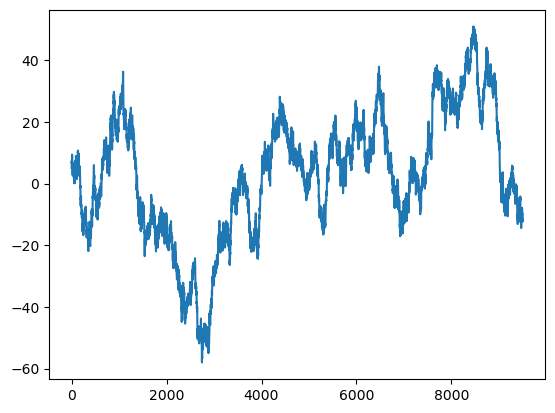

In [65]:
plt.plot(theta_samples)

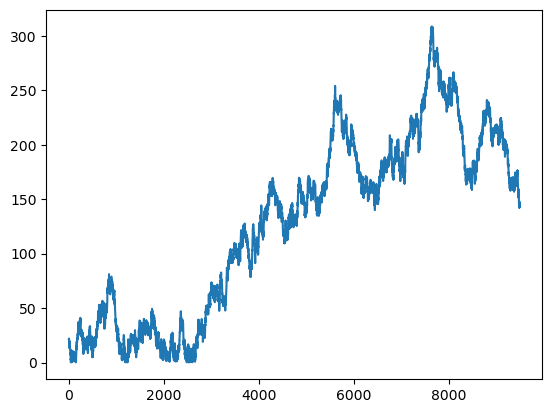

In [66]:
plt.plot(tau_samples)

In [67]:
np.quantile(theta_samples, [0.025, 0.975])

array([-46.39925817,  38.62532771])

In [68]:
np.quantile(1/(tau_samples**0.5), [0.025, 0.975])

array([0.06146852, 0.48466324])

There's no need to determine the full conditional distribution with MH because an unnormalized joint posterior is enough. Our  acceptance ratios are based on ratios of this distribution, so any normalizing constants we go through the pain of figuring out will just cancel with each other anyway.

# Question 3
---
The ratios involving $q$ cancel because 
$$q(0|1) = \frac 12 = q(1|0)$$
Meanwhile we have
$$\begin{array}{ccc} p(0) = \frac13 & \text{ and } & p(1) = \frac23 \end{array}$$
Since the proposal ratio is symmetric, it cancels so our acceptance probability becomes
$$A(x^{(t-1)}, \tilde x^{(t)}) = \min\left(1, \frac{p(\tilde x^{(t)})}{p(x^{(t-1)})}\right)$$
Suppose $x^{(t-1)} = 0$. The proposal $\tilde x^{(t)} = 1$ happens with probability $1/2$, and
$$A(0,1) = \min\left(1, \frac{2/3}{1/3}\right) = \min(1, 2) = 1$$
so the probability of transitioning to $1$ from $0$ is $1/2$. The probability of staying at $0$ is thus $1 - 1/2 = 1/2$. \\
Suppose $x^{(t-1)} = 1$. The proposal $\tilde x^{(t)} = 0$ happens with probability $1/2$, and 
$$A(1,0) = \min\left(1, \frac{1/3}{2/3}\right) = \min(1, 0.5) = 0.5$$
so the probability of transitioning to $0$ from $1$ is $1/4$. The probability of staying at $1$ is thus $1 - 1/4 = 3/4$. We conclude that 
$$K = \begin{pmatrix} 0.5 & 0.25 \\ 0.5 & 0.75 \end{pmatrix}$$
as desired. 